# Data Analysis Notebook For Hartree-Fock Stability
---

This notebook and the corresponding python file at pyfiles.HFSAnalyzer contain all data analysis and plotting scripts used in the Hatree-Fock Stability of the Homogeneous Electron Gas (HEG). The Data all comes from the executables in the src directory of the project. The logfiles are all in .json format, allowing for easy parsing, while also being human readable (except some large arrays). 

In [1]:
from collections import defaultdict
import glob
import json
import math
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
import qgrid
settings = {
    'fullWidthRows': True,
    'syncColumnCellResize': True,
    'forceFitColumns': False,
    'defaultColumnWidth': 100,
    'rowHeight': 28,
    'enableColumnReorder': False,
    'enableTextSelectionOnCells': True,
    'editable': False,
    'autoEdit': False,
    'explicitInitialization': True,
    'maxVisibleRows': 20,
    'minVisibleRows': 0,
    'sortable': True,
    'filterable': True,
    'highlightSelectedCell': False,
    'highlightSelectedRow': True
}
qgrid.set_defaults(show_toolbar=True, grid_options=settings)
qgrid.enable()

## Load the Data
---

The data is parsed and collected in a pandas dataframe

In [2]:
def multiple_replace(string, replacements):
    """Replace all occurances of replacements' keys in string with corresponding values."""
    d = dict(replacements)
    pattern = re.compile(r'\b(' + '|'.join(d.keys()) + r')\b')
    return pattern.sub(lambda x: d[x.group()], string)

dicts = []
for fname in glob.glob('/home/evan/Documents/HF-Stability/data/*.json'):
    with open(fname, 'r') as f:
        s = f.read()
    corrected = multiple_replace(s, {'inf': 'Infinity', 'nan': 'NaN'})        
    dicts.append(json.loads(corrected))
    
df = pd.DataFrame(dicts)
df.head()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

## Ensure expected typecasts

In [3]:
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str).str.lstrip().str.rstrip()    
df['rs'] = df['rs'].astype(float)
df['File'] = df['File'].astype(str)
df['total_calculation_time'] = df['total_calculation_time'].astype(float)
df['computation_started'] = pd.to_datetime(df['computation_started'])
df['computation_finished'] = pd.to_datetime(df['computation_finished'])
df['build_date'] = pd.to_datetime(df['build_date'].str.replace('-', ' '))
mask = df['File'].str.contains('scaling_test')
scaling_test = df[mask]
df = df[np.logical_not(mask)]

df.head()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

## Clean Data and simple calcs


In [14]:
# Remove data with critical values missing
df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk'], inplace=True)

# Of course use_delta_1D must be false for ndim=2, 3
df.loc[np.logical_or(df['NDIM'] == 2, df['NDIM'] == 3), 'use_delta_1D'] = False
df['use_delta_1D'] = df['use_delta_1D'].astype(bool)

df = df.drop_duplicates(subset=['NDIM', 'rs', 'Nk', 'mycase', 'twoE_parameter_1dCase', 'use_delta_1D'])

# The matrix was diagonalized by factoring into A + B and A - B for singlet and triplet cases
# It seems very likely that the offdiagonal components mean that these have equivalent
# eigenvalues, but I was unable to prove this definitively. To be safe, I just did all cases. 
# Thus the actual instability eigenvalue is the minimum of the eigenvalues of A + B and A - B. 
df['triplet_instability'] = df[['dav_triplet_a_minus_b', 'dav_triplet_a_plus_b']].min(axis=1)
df['singlet_instability'] = df[['dav_singlet_a_minus_b', 'dav_singlet_a_plus_b']].min(axis=1)

df.head()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

## Scaling Testing for 2D and 3D case

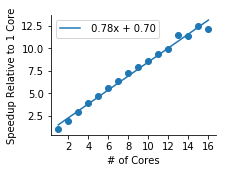

In [5]:
scaling_test['n_per_proc'] = scaling_test['Nmat'] / scaling_test['n_procs']
scaling_test['n_cores'] = scaling_test['n_procs'] // 32

scaling_test = scaling_test[scaling_test.n_cores != 60]

def add_speedup(df):
    min_row = df[df['n_cores'] == min(df['n_cores'])]
    single_core_time = np.average(min_row['total_calculation_time'] * min_row['n_cores'])
    df['Speedup'] = pd.to_numeric(single_core_time) / df['total_calculation_time']
    return df
    
scaling_test = scaling_test.groupby('NDIM').apply(add_speedup)


def linefit(x, y, **kwargs):
    """Wrapper to allow for varied scales in plots"""
    ax = plt.gca()

    plt.scatter(x, y, **kwargs)
  
    coeffs = np.polyfit(x, y, deg=1)
    poly = np.poly1d(coeffs)
    fitfunc = lambda x: poly(x)
    xvals = np.linspace(min(x), max(x), 500)
    line = plt.plot(xvals, fitfunc(xvals), label='{:5.2f}x +{:5.2f}'.format(*coeffs))
    legend = plt.legend(handles=line, loc=0)
    ax.add_artist(legend)
    
    
scaling_test = scaling_test.query('NDIM == 3')
grid = sns.FacetGrid(scaling_test, col='NDIM', sharey=False, sharex=False, size=2.5, aspect=1.3)
grid = grid.map(linefit, 'n_cores', 'Speedup').set_titles("")
grid.set_axis_labels('# of Cores', 'Speedup Relative to 1 Core')
#plt.suptitle('Strong Parallel Scaling')
plt.subplots_adjust(top=0.9)
from matplotlib.ticker import MaxNLocator
#...
ax = plt.gca()
#...

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("../doc/images/parallel-scaling.eps", bbox_inches='tight')
plt.show()

## Testing Convergence of Stability Curves with # of K-points

In [52]:
from scipy.interpolate import interp1d
from scipy import optimize

df['Nkpoints'] = df['Nk'] ** df['NDIM']

def crossover(df, x, y, interp1d_args=(), interp1d_kwargs=None):
    temp = df.dropna(subset=[x, y])
    
    try:
        x, y = temp[x], temp[y]
        
        if interp1d_kwargs is None:
            interp1d_kwargs = {}

        f = interp1d(x, y, *interp1d_args, **interp1d_kwargs)

        return optimize.brentq(f, min(x), max(x), xtol=0.001)
    except:
        return np.nan


trip_onset = (df.groupby(['Nk', 'NDIM'])
        .apply(lambda d: crossover(d, 'rs', 'triplet_instability', interp1d_kwargs={'kind': 'linear'}))
        .reset_index()
        .rename(columns={0: 'Crossover'})
)

sing_onset = (df.groupby(['Nk', 'NDIM'])
        .apply(lambda d: crossover(d, 'rs', 'singlet_instability'))
        .reset_index()
        .rename(columns={0: 'Crossover'})
).dropna()

trip_onset.query('NDIM==1')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

{1:      Nk  NDIM  Crossover  Nkpoints
 0    10     1   0.077084        10
 3    20     1   2.469276        20
 6    30     1   0.936929        30
 9    40     1   0.938340        40
 13   50     1   0.009766        50
 15   60     1   0.009766        60
 17   70     1   0.009766        70
 19   80     1        NaN        80
 20  100     1   0.009766       100
 21  200     1   0.009766       200
 22  300     1   0.009766       300
 23  400     1   0.009766       400
 24  500     1   0.009766       500, 2:     Nk  NDIM  Crossover  Nkpoints
 4   24     2   0.957382       576
 8   34     2   1.007725      1156
 11  44     2   0.889124      1936
 14  54     2   0.883390      2916
 16  64     2   0.823436      4096
 18  77     2        NaN      5929, 3:     Nk  NDIM  Crossover  Nkpoints
 1   11     3        NaN      1331
 2   16     3   3.928778      4096
 5   24     3   3.540575     13824
 7   32     3   3.466136     32768
 10  40     3   3.239982     64000
 12  48     3   3.153981    1105

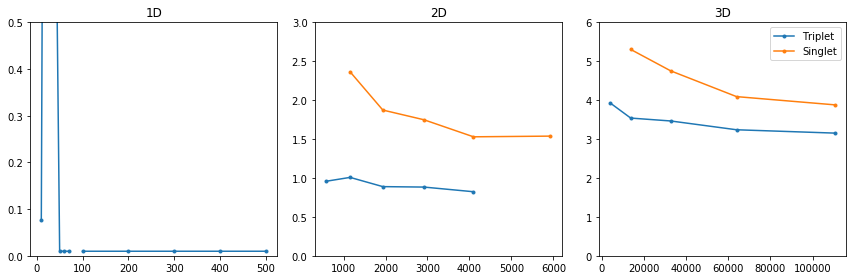

In [49]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))


trip_onset['Nkpoints'] = trip_onset['Nk'] ** trip_onset['NDIM']
sing_onset['Nkpoints'] = sing_onset['Nk'] ** sing_onset['NDIM']
trip = {k: v for k, v in trip_onset.groupby('NDIM')}
sing = {k: v for k, v in sing_onset.groupby('NDIM')}
display(trip)



axes[0].plot(trip[1]['Nkpoints'], trip[1]['Crossover'], '.-', label='Triplet')
# axes[0].plot(sing[1]['Nkpoints'], sing[1]['Crossover'], '.-', label='Singlet')
axes[0].set_title('1D')
axes[0].set_ylim(0, 0.5)


axes[1].plot(trip[2]['Nkpoints'], trip[2]['Crossover'], '.-', label='Triplet')
axes[1].plot(sing[2]['Nkpoints'], sing[2]['Crossover'], '.-', label='Singlet')
axes[1].set_ylim(0, 3)
axes[1].set_title('2D')

axes[2].plot(trip[3]['Nkpoints'], trip[3]['Crossover'], '.-', label='Triplet')
axes[2].plot(sing[3]['Nkpoints'], sing[3]['Crossover'], '.-', label='Singlet')
axes[2].set_ylim(0, 6)
axes[2].set_title('3D')

plt.legend()
plt.tight_layout()
plt.show()

# Finding the crossover rs for highest gridpoints

In [8]:
trip_onset.groupby('NDIM').apply(lambda d: d.loc[d['Nk'].idxmax()]['Crossover'])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

# Singlet Stability Curves

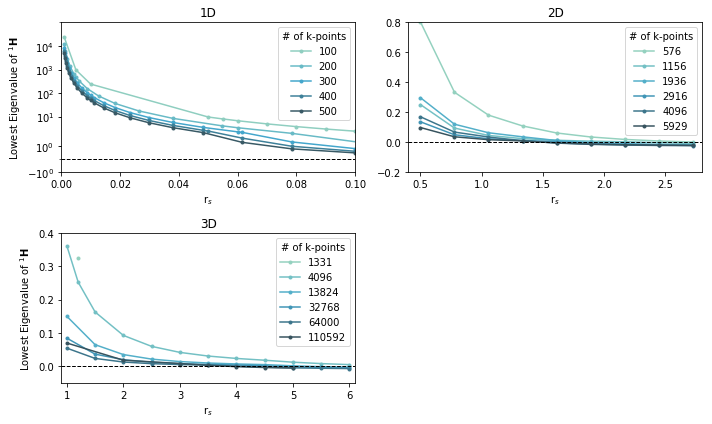

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
subset = (df
          .query('NDIM != 1 or Nk >= 100') # drop low Nk 1D calcs
         )

xlims = ((0, 0.1), (0.4, 2.8), (0.9, 6.1)) 
ylims = ((-1, 10**5), (-0.2, 0.8), (-0.05, 0.4))


for xlim, ylim, ax, (ndim, subset) in zip(xlims, ylims, axes.reshape(-1), subset.groupby('NDIM')):
    Nkgroups = subset.groupby('Nk')
    cp = reversed(sns.color_palette("GnBu_d", len(Nkgroups)))
    
    temp = subset[['rs', 'singlet_instability', 'Nkpoints']].pivot(index='rs', columns='Nkpoints')
    temp = temp.reset_index()
    temp = temp.rename(columns={'singlet_instability': 'eval'})
    
    s = temp.to_csv(na_rep="    'NaN'   ", index=False, float_format='%12.5f')
    lines = s.split('\n')[1:]
    header = ','.join(['{:^12}'.format('rs')]  + ['{:^12}'.format('Nk='+s) for s in lines[0].split(',')[1:]])
    lines[0] = header
    s = '\n'.join(lines)
    fname = 'singlet_instability_vs_rs_{}d.csv'.format(ndim)
    with open(fname, 'w') as f:
        f.write(s)
        
    
    for color, (Nk, subsubset) in zip(cp, Nkgroups):
        x = subsubset['rs']
        y = subsubset['singlet_instability']
        x, y = zip(*sorted([tup for tup in zip(x, y)], key=lambda tup: tup[0]))
        ax.plot(x, y, '.-', c=color, label=Nk**ndim)
    
    ax.plot(np.linspace(*xlim, 10**3), np.zeros(10**3), 'k--', linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('r$_s$')
    ax.set_title(str(ndim) + 'D')
    ax.legend(title='# of k-points')

axes[0,0].set_yscale('symlog')
axes[0,0].set_yticks([-1, 1, 10**1, 10**2, 10**3, 10**4])
axes[0,0].set_ylabel('Lowest Eigenvalue of ${}^1\mathbf{H}$')
axes[1,0].set_ylabel('Lowest Eigenvalue of ${}^1\mathbf{H}$')

    
axes[1, 1].remove()
plt.tight_layout()

# Triplet Stability Curves

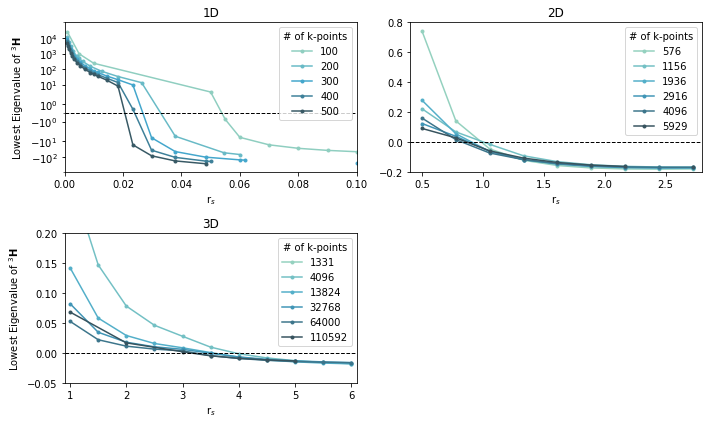

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
subset = (df
          .query('NDIM != 1 or Nk >= 100') # drop low Nk 1D calcs
         )

xlims = ((0, 0.1), (0.4, 2.8), (0.9, 6.1)) 
ylims = ((-10**3, 10**5), (-0.2, 0.8), (-0.05, 0.2))


for xlim, ylim, ax, (ndim, subset) in zip(xlims, ylims, axes.reshape(-1), subset.groupby('NDIM')):
    Nkgroups = subset.groupby('Nk')
    cp = reversed(sns.color_palette("GnBu_d", len(Nkgroups)))
    for color, (Nk, subsubset) in zip(cp, Nkgroups):
        x = subsubset['rs']
        y = subsubset['triplet_instability']
        x, y = zip(*sorted([tup for tup in zip(x, y)], key=lambda tup: tup[0]))
        ax.plot(x, y, '.-', c=color, label=Nk**ndim)
    
    ax.plot(np.linspace(*xlim, 10**3), np.zeros(10**3), 'k--', linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('r$_s$')
    ax.set_title(str(ndim) + 'D')
    ax.legend(title='# of k-points')

axes[0,0].set_yscale('symlog')
axes[0,0].set_yticks([-10**2, -1, -10**1, 1, 10**1, 10**2, 10**3, 10**4])
axes[0,0].set_ylabel('Lowest Eigenvalue of ${}^3\mathbf{H}$')
axes[1,0].set_ylabel('Lowest Eigenvalue of ${}^3\mathbf{H}$')

    
axes[1, 1].remove()
plt.tight_layout()

In [11]:
def series_to_html(self):
    df = pd.DataFrame(self)
    df.columns = ['{}'.format(self.dtype)]
    return df._repr_html_()

pd.Series._repr_html_ = series_to_html
trip_onset.groupby('NDIM').apply(lambda d: d.loc[d['Nk'].idxmax()]['Crossover'])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

In [12]:


trip_onset.groupby('NDIM').apply(lambda d: d.loc[d['Nk'].idxmax()]['Crossover'])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defaultColumnWidth': 100, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': False, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 20, 'minVisibleRows': 0, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)